<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Dataset" data-toc-modified-id="Load-Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Dataset</a></span></li><li><span><a href="#Vanilla-SGC" data-toc-modified-id="Vanilla-SGC-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Vanilla SGC</a></span><ul class="toc-item"><li><span><a href="#Train-and-test" data-toc-modified-id="Train-and-test-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Train and test</a></span></li></ul></li><li><span><a href="#SGC-with-label-smoothing" data-toc-modified-id="SGC-with-label-smoothing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>SGC with label smoothing</a></span><ul class="toc-item"><li><span><a href="#Convert-to-one-hot" data-toc-modified-id="Convert-to-one-hot-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Convert to one hot</a></span></li><li><span><a href="#Train-and-test" data-toc-modified-id="Train-and-test-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train and test</a></span></li></ul></li></ul></div>

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from input_data import Dataset

# Load Dataset

In [2]:
Data = Dataset('cora', seed=42)
print(f'Pre-processing time {Data.precompute_time:.2f}s')

Pre-processing time 0.02s


# Vanilla SGC

## Train and test

In [3]:
tf.random.set_seed(42)
SGC = keras.Sequential([keras.layers.Dense(units=Data.n_classes, kernel_regularizer=keras.regularizers.l2(1e-5), activation='softmax')])
SGC.compile(optimizer=keras.optimizers.Adam(0.01), 
                loss=keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                min_delta=1e-3,
                                                patience=6,
                                                mode='max',
                                              )
history = SGC.fit(x=Data.train_feat, 
                    y=Data.y_train, 
                    epochs=100, 
                    verbose=None,
                    validation_data=(Data.val_feat, Data.y_val),
                    shuffle=True,
                    batch_size=128,
                    callbacks=[early_stopping],
    )
loss, acc = SGC.evaluate(
            x=Data.test_feat, 
            y=Data.y_test, 
            verbose=None,
            batch_size=128
            )
print(f'Converged after {history.epoch[-1] + 1} iterations, accuracy {acc*100:.2f}%')

Converged after 18 iterations, accuracy 83.39%


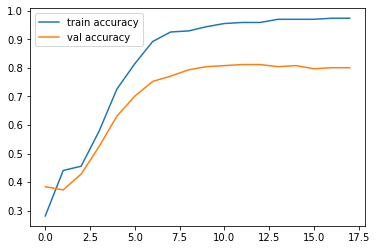

In [4]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train accuracy', 'val accuracy'])
plt.show()

# SGC with label smoothing
When we apply the cross-entropy loss to a classification task, we're expecting true labels to have 1, while the others 0. In other words, we have no doubts that the true labels are true, and the others are not. Is that always true? Maybe not. Many manual annotations are the results of multiple participants. They might have different criteria. They might make some mistakes. They are human, after all. As a result, the ground truth labels we have had perfect beliefs on are possible wrong.

One possibile solution to this is to relax our confidence on the labels. For instance, we can slighly lower the loss target values from 1 to, say, 0.9. And naturally we increase the target value of 0 for the others slightly as such. This idea is called label smoothing.

see also: [When Does Label Smoothing Help?](https://arxiv.org/abs/1906.02629) and [GitHub](https://github.com/Kyubyong/label_smoothing)

## Convert to one hot

In [5]:
one_hot = np.eye(Data.n_classes)
y_train = one_hot[Data.y_train]

# label smoothing
confidence = 0.2
y_train =  (1. - confidence)*y_train + confidence / Data.n_classes

y_val = one_hot[Data.y_val]
y_test = one_hot[Data.y_test]

## Train and test

In [6]:
tf.random.set_seed(42)
SGC = keras.Sequential([keras.layers.Dense(units=Data.n_classes, kernel_regularizer=keras.regularizers.l2(1e-5), activation='softmax')])
SGC.compile(optimizer=keras.optimizers.Adam(0.01), 
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                min_delta=1e-3,
                                                patience=6,
                                                mode='max',
                                              )
history = SGC.fit(x=Data.train_feat, 
                    y=y_train, 
                    epochs=100, 
                    verbose=None,
                    validation_data=(Data.val_feat, y_val),
                    shuffle=True,
                    batch_size=128,
                    callbacks=[early_stopping],
    )
loss, acc = SGC.evaluate(
            x=Data.test_feat, 
            y=y_test, 
            verbose=None,
            batch_size=128
            )
print(f'Converged after {history.epoch[-1] + 1} iterations, accuracy {acc*100:.2f}%')

Converged after 20 iterations, accuracy 84.73%


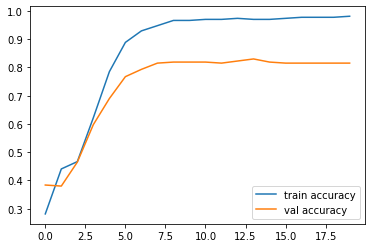

In [7]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train accuracy', 'val accuracy'])
plt.show()